---
## Part I: Data Collection

This code section downloads the price data needed to construct images from Yahoo Finance. It reads in the stock codes to download from `Data/stock_tickers_40.csv`. The resulting data is saved in a dictionary called `stock_data`.

#### Libraries

In [1000]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import ast
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display
import math
import seaborn as sns

#### Functions

In [2]:
# Function to download price data from Yahoo Finance and handle invalid ticker codes
def download_prices(ticker, start_date, end_date, suffix=".JO"):
    try:
        ticker_with_suffix = f"{ticker}{suffix}"
        stock_data = yf.download(ticker_with_suffix, start=start_date, end=end_date)
        stock_data = stock_data[['Open', 'Close', 'High', 'Low', 'Volume']]
        stock_data['Ticker'] = ticker
        return stock_data
    
    except yf.TickerError as e:
        print(f"Invalid ticker {ticker}: {e}")
        return pd.DataFrame()
    
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return pd.DataFrame()

#### Parameters

In [382]:
# Data range
start_date = datetime(1999, 12, 31)
end_date = datetime(2023, 11, 30)

# File paths
fpath_tickers = "Data/stock_tickers_40.csv"
fpath_price_data = "Data/price_data.csv"
fpath_image_data = "Data/Images/Top40/"

# Image Sizes
image_widths = [5, 20, 60] # in trading days
image_widths = [5, 20] # in trading days
image_heights = [32, 64, 96] # in pixels: for charts without volume/ma
image_heights_vma = [25, 51, 76] # in pixels: for charts with volume/ma
image_heights_vol = [6, 12, 19] # in pixels: for volume bar charts
ma_settings = [True, False] # include/exclude volume/ma indicators on chart

#### Download Data from YF

In [384]:
# Loop through tickers csv to download all price data.
tickers_df = pd.read_csv(fpath_tickers)
stock_prices = {}
error_stocks = []
for ticker in tickers_df['ticker']:
    stock_data = download_prices(ticker, start_date, end_date)
    if not stock_data.empty:
        stock_prices[ticker] = stock_data
        print(f"Downloaded data for {ticker}")
    else:
        error_stocks.append(ticker)
        
# Tickers
print("Invalid tickers:", error_stocks)
valid_tickers = list(stock_prices.keys())
print("Valid tickers:", valid_tickers)

[*********************100%%**********************]  1 of 1 completed
Downloaded data for ANH
[*********************100%%**********************]  1 of 1 completed
Downloaded data for ABG
[*********************100%%**********************]  1 of 1 completed
Downloaded data for ANG
[*********************100%%**********************]  1 of 1 completed
Downloaded data for AGL
[*********************100%%**********************]  1 of 1 completed
Downloaded data for AMS
[*********************100%%**********************]  1 of 1 completed
Downloaded data for APN
[*********************100%%**********************]  1 of 1 completed
Downloaded data for BTI
[*********************100%%**********************]  1 of 1 completed
Downloaded data for BHG
[*********************100%%**********************]  1 of 1 completed
Downloaded data for BID
[*********************100%%**********************]  1 of 1 completed
Downloaded data for BVT
[*********************100%%**********************]  1 of 1 completed
D

In [994]:
# OUTPUT 1:
stock_prices['NED']

,Open,Close,High,Low,Volume,Ticker
Date,,,,,,
2000-01-04,13800.0,13600.0,13960.0,13600.0,300476,NED
2000-01-05,13500.0,13120.0,13500.0,13000.0,270635,NED
2000-01-06,13400.0,12780.0,13400.0,12780.0,110879,NED
2000-01-07,12800.0,12800.0,13800.0,12800.0,260708,NED
2000-01-10,13500.0,14600.0,14900.0,13500.0,419092,NED
...,...,...,...,...,...,...
2023-11-23,20995.0,21146.0,21308.0,20811.0,1684544,NED
2023-11-24,21490.0,21534.0,21660.0,20965.0,1108328,NED
2023-11-27,21370.0,21394.0,21479.0,21151.0,1315922,NED


---
## Part II: Image Creation
This section creates all the images needed for the analysis.

#### Helper Functions
Functions below are used to create the images (price chart, volatility chart,  price/volatility chart)

In [385]:

# Get correct value of y-pixel
def get_px(val, min_val, max_val, height):
    out = (val - min_val) / (max_val - min_val)
    out = height - 1 - int(out*(height-1))
    return out

# Bresenham's line algorithm to plot a line between (a,b) and (x,y)
def draw_line(matrix, a, b, x, y, color = 255):
    dx = abs(x - a)
    dy = abs(y - b)
    sx = 1 if a < x else -1
    sy = 1 if b < y else -1
    err = dx - dy
    while a != x or b != y:
        matrix[b, a] = color

        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            a += sx
        if e2 < dx:
            err += dx
            b += sy
    matrix[y, x] = color


# Create price chart
def create_price_chart(stock_data, image_width, image_height, MA=False):
    # Blank image
    img = np.zeros((image_height, image_width), dtype=int)
    bar_width = 3

    # Normalise prices to fit height
    if MA:
        min_price = stock_data[['Low', 'MA', 'Close', 'Open']].min().min()
        max_price = stock_data[['High', 'MA', 'Close', 'Open']].max().max()
    else:
        min_price = stock_data[['Low', 'Close', 'Open']].min().min()
        max_price = stock_data[['High', 'Close', 'Open']].max().max()
    price_range = max_price - min_price

    # Handle issue of 0 price change
    if price_range == 0:
        return None
    
    prev_ma = None
    for i, (_, row) in enumerate(stock_data.iterrows()):
        day_open = row['Open']
        day_close = row['Close']
        day_high = row['High']
        day_low = row['Low']
        day_ma = row['MA']
        
        bar_x = i * bar_width + 1 # X-coordinate
        
        # Draw OPEN pixel
        if not np.isnan(day_open):
            open_px = get_px(day_open, min_price, max_price, image_height)
            img[open_px, bar_x - 1] = img[open_px, bar_x] = 255
            
        # Draw CLOSE pixel
        if not np.isnan(day_close):
            close_px = get_px(day_close, min_price, max_price, image_height)
            img[close_px, bar_x] = img[close_px, bar_x + 1] = 255
            
        # Draw HIGH-LOW line          
        if any(not pd.isna(val) for val in [day_high, day_low]):
            high_px = get_px(day_high, min_price, max_price, image_height)
            low_px = get_px(day_low, min_price, max_price, image_height)
            img[high_px:low_px+1, bar_x] = 255

        # Draw MA line
        ma_px = get_px(day_ma, min_price, max_price, image_height)
        if prev_ma is not None and MA:
            draw_line(img, (bar_x - bar_width), prev_ma, bar_x, ma_px)
        prev_ma = ma_px

    # Return the list of pixel values
    return img

# Create volume chart
def create_vol_chart(stock_data, vol_image_width, vol_image_height):
    img = np.zeros((vol_image_height, vol_image_width), dtype=int)
    bar_width = 3

    # Handle no vol data
    vol_range = stock_data[['Volume']].max().max()
    if vol_range == 0 or pd.isna(vol_range):
        return img
    bar_width = 3

    # Plot vol bars on the image
    for i, (_, row) in enumerate(stock_data.iterrows()):
        day_close = row['Volume']
        
        # Draw volume bar
        if not np.isnan(day_close):
            bar_x = i * bar_width + 1
            open_px = vol_image_height
            close_px = get_px(day_close, 0, vol_range, vol_image_height)
            img[close_px:open_px, bar_x] = 255

    return img

# Combine price/vol chart
def create_price_vol_chart(stock_data, image_width, vol_image_height, price_image_height, MA = True):
    imgprice = create_price_chart(stock_data, image_width, price_image_height, MA=MA)
    if imgprice is None:
        return None
    imgvol = create_vol_chart(stock_data, image_width, vol_image_height)
    blank_row = np.zeros(image_width).astype(int).tolist()
    out = np.vstack((imgprice, blank_row, imgvol))
    return out

# function that creates a data row:
# start_date | end_date | [img_data] | fwd_ret | ticker
def create_data(tmp_data, iwidth, iheight, ma_incl, ivheight = None):
    if ma_incl:
        img_data = create_price_vol_chart(tmp_data, iwidth*3, ivheight, iheight)
        img_data = None if img_data is None else img_data.flatten().tolist()
    else:
        img_data = create_price_chart(tmp_data, iwidth*3, iheight)
        img_data = None if img_data is None else img_data.flatten().tolist()
    sdate = tmp_data.index[0].to_pydatetime()
    edate = tmp_data.index[iwidth-1].to_pydatetime()
    fwd_ret_cols = [col for col in tmp_data.columns if col.startswith("Fwd_Ret")]
    fwd_ret_values = tmp_data[fwd_ret_cols].iloc[iwidth-1].values.tolist()
    tmp_row = [sdate, edate, img_data] + fwd_ret_values + [ticker]
    return tmp_row

# Plot image from a vector
def plot_vimg(vimg, width = 5):
    vimg = np.array(vimg).reshape(int(len(vimg)/(width*3)),width*3)
    plt.imshow(vimg, cmap='gray', interpolation='nearest')
    plt.show()


#### Create images for each [ticker x time period x image type]
This code loops over `ma_include`,`image_widths`, and `valid_tickers` to create [price, price+vol] and [5, 20] width charts for every ticker on every day in the date range.\

**THIS CODE TAKE APPROXIAMATELY 30 MINUTES TO RUN**

In [386]:
# Create a rolling window of images (window is equal to image_width/3, i.e. number of trading days)
    
# Loop over:
# - ma_include (to create regular or volume images)
# - image_withs (to create images with different trading days)
# - valid_tickers (to create images for different tickers)

for ma_include in ma_settings:
    ma_type = "VMA" if ma_include else "Regular"
    print(f"""
    ++++++++++++++++++++++++++++++++++++++++++++\n
    Creating {ma_type} Images...\n
    ++++++++++++++++++++++++++++++++++++++++++++""")

    for c in range(0, len(image_widths)):    
        width = image_widths[c]
        
        if ma_include:
            height = image_heights_vma[c]
            vheight = image_heights_vol[c]
        else:
            height = image_heights[c]
            vheight = None
        
        print(f"""
        ======================\n
        Creating {width}-width...\n
        ======================""")

        df_large = pd.DataFrame(columns=['start_date', 'end_date', 'img_data'] +
                                [f'Fwd_Ret_{s}' for s in image_widths] + ['ticker'])

        t = 1
        for ticker in valid_tickers:
            print(f"""
            Processing {ticker} ({t}/{len(valid_tickers)})...
            """)
            t = t + 1

            # Get data and add MA/Fwd_Ret columns
            data = stock_prices[ticker].copy()
            data['MA'] = data['Close'].fillna(method='ffill').rolling(window=width).mean()
            # Add Fwd_Ret columns (i.e. the predicted variables)
            for w in image_widths:
                column_name = f'Fwd_Ret_{w}'
                data[column_name] = data['Close'].pct_change(periods=w).shift(-w)
            data = data.iloc[width:-(width)] # chop first/last values since they are missing MA/Fwd_Ret values

            # Loop over entries and create a dataframe of images over a rolling window
            df_res = pd.DataFrame(columns=df_large.columns.tolist())
            for i in range(width, len(data)):
                subset = data.iloc[(i - width):i]
                row_data = create_data(subset, width, height, ma_include, vheight)
                df_res = pd.concat([df_res, pd.DataFrame([row_data], columns=df_res.columns)], ignore_index=True)
                df_res = df_res[df_res['img_data'].notna()] # Remove entries with no image
            df_large = pd.concat([df_large, df_res], ignore_index=True)

        # Save as csv
        if ma_include:
            out_name = f"{fpath_image_data}i{width}_vma.csv"
        else:
            out_name = f"{fpath_image_data}i{width}.csv"
        df_large.to_csv(out_name, index=False)
        print(f'Created file {out_name}')


    ++++++++++++++++++++++++++++++++++++++++++++

    Creating VMA Images...

    ++++++++++++++++++++++++++++++++++++++++++++


        Creating 5-width...


            Processing ANH (1/41)...
            

            Processing ABG (2/41)...
            

            Processing ANG (3/41)...
            

            Processing AGL (4/41)...
            

            Processing AMS (5/41)...
            

            Processing APN (6/41)...
            

            Processing BTI (7/41)...
            

            Processing BHG (8/41)...
            

            Processing BID (9/41)...
            

            Processing BVT (10/41)...
            

            Processing CPI (11/41)...
            

            Processing CLS (12/41)...
            

            Processing DSY (13/41)...
            

            Processing EXX (14/41)...
            

            Processing FSR (15/41)...
            

            Processing GFI (16/41)...
            

            Proce


            Processing INP (22/41)...
            

            Processing MNP (23/41)...
            

            Processing MRP (24/41)...
            

            Processing MTN (25/41)...
            

            Processing NPN (26/41)...
            

            Processing NED (27/41)...
            

            Processing NRP (28/41)...
            

            Processing NPH (29/41)...
            

            Processing OMU (30/41)...
            

            Processing PRX (31/41)...
            

            Processing RNI (32/41)...
            

            Processing REM (33/41)...
            

            Processing CFR (34/41)...
            

            Processing SLM (35/41)...
            

            Processing SOL (36/41)...
            

            Processing SHP (37/41)...
            

            Processing SSW (38/41)...
            

            Processing SBK (39/41)...
            

            Processing VOD (40/41)...
            

           

#### Create example charts
These saves example images

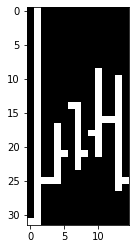

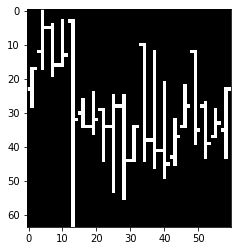

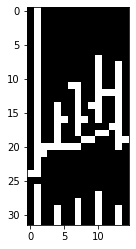

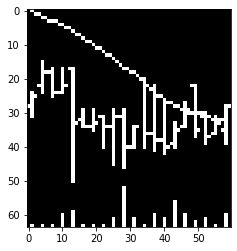

In [996]:
# Figure 3:
fnames = ['i5', 'i20', 'i5_vma', 'i20_vma']
widths = [5, 20, 5, 20]
for fname, w in zip(fnames, widths):
    df_tmp = pd.read_csv(f'Data/Images/Top40/{fname}.csv', nrows=1)
    img_data = ast.literal_eval(df_tmp['img_data'][0])
    img_data = np.array(img_data).reshape(int(len(img_data)/(w*3)),w*3)
    plt.imshow(img_data, cmap='gray', interpolation='nearest')
    output_path = f'Images/{fname}.png'
    plt.savefig(output_path)  # Save the plot as an image
    plt.show()

In [997]:
# Output 2
df_tmp

,start_date,end_date,img_data,Fwd_Ret_5,Fwd_Ret_20,ticker
0,2016-02-12,2016-03-10,"[0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",-0.006258,0.021582,ANH


---
## Part III: Model Creation and Training
The code below creates and trains the CNN. `PyTorch` and `sklearn` are used for implementation.

#### Libraries

In [871]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import random

random_seed=30224
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

#### Parameter selection

In [ ]:
predict_periods = [5] # Periods for which the model will aim to predict returns
backtest_start = datetime(2015, 1, 1)
validation_size = 0.3 # size of validation in train/validation set
outlier_max = 1 # drop data with weekly returns greater than this
outlier_min = -0.90 # drop data with weekly returns less than this
patience = 2 # number of epochs without improvement in loss after which training is stopped
max_epochs = 20

batch_size = 128
learn_rate = 0.00001

#### Data Preparation

In [989]:
m = 0
w = 0
p = 0

ma_include = ma_settings[m]
image_width = image_widths[w]*3
image_height = image_heights[w]
predict_ahead = predict_periods[p]
fpath_data_file = f'Data/Images/Top40/i{int(image_width/3)}_vma.csv' if ma_include \
                    else f'Data/Images/Top40/i{int(image_width/3)}.csv'
data = pd.read_csv(fpath_data_file)

# Drop outliers (simply stocks with weekly returns >100% or <-90%)
data = data[(data['Fwd_Ret_5'] > outlier_min) & (data['Fwd_Ret_5'] < outlier_max)]

In [990]:
# Get data in correct format
image_data = data['img_data'].apply(ast.literal_eval)
image_data = np.array([np.array(a) for a in image_data])
image_data = image_data.reshape(-1, image_height, image_width).astype(np.uint8)
labels = data[f"Fwd_Ret_{predict_ahead}"]
labels = np.array((labels > 0)*1) # 1 = positive return; 0 = negative return

In [991]:
# Split into (train+validate) and test sets by date
index_tv = data[pd.to_datetime(data['end_date']) < backtest_start].index.tolist()
x_tv = np.array([image_data[i] for i in index_tv])
y_tv = np.array([labels[i] for i in index_tv])

# Split (train+validate) sets randomly for approx. equal class labels
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=validation_size, random_state=random_seed)
for train_index, valid_index in stratified_split.split(x_tv, y_tv):
    x_train, x_valid = x_tv[train_index], x_tv[valid_index]
    y_train, y_valid = y_tv[train_index], y_tv[valid_index]

# Check split of class labels
unique_values, counts = np.unique(y_train, return_counts=True)
value_counts = dict(zip(unique_values, counts))
print(f"Label counts: {value_counts}")

Label counts: {0: 36686, 1: 40548}


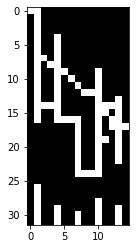

In [992]:
# Sanity check that images are loaded correctly
plt.imshow(image_data[350], cmap='gray', interpolation='nearest')
plt.show()

In [993]:
# Create a custom dataset class
class ChartDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].reshape(image_height,image_width).astype(np.uint8)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create dataloaders
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = ChartDataset(x_train, y_train, transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_dataset = ChartDataset(x_valid, y_valid, transform)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#### Model Specification

In [916]:
# Model for 5 trading days
class i5CNN(nn.Module):
    
    # Set weights/bias
    def init_weights(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_
            m.bias.data.fill_(0.01)
    
    def __init__(self):
        super(i5CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, (5, 3), padding=(2, 1), stride=(1, 1), dilation=(1, 1)), #out: (N, 64, 32, 15)
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(),
            nn.MaxPool2d((2,1)) #out: (N, 64, 16, 15)
        ) 
        self.layer1 = self.layer1.apply(self.init_weights)
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, (5, 3), padding=(2, 1), stride=(1, 1), dilation=(1, 1)), #out: (N, 128, 16, 15)
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(),
            nn.MaxPool2d((2,1)) #out: (N, 128, 8, 15)
        )
        self.layer2 = self.layer2.apply(self.init_weights)
        
        
        self.DropOut = nn.Dropout(p=0.5)
        self.FC = nn.Linear(128*8*15, 2)
        self.init_weights(self.FC)
        self.Softmax = nn.Softmax(dim=1)

    def forward(self, x): # in: (N, 32, 15)
        x = x.unsqueeze(1).to(torch.float32)   # out: (N, 1, 32, 15)
        x = self.layer1(x) # out: (N, 64, 16, 15)
        x = self.layer2(x) # out: (N, 128, 8, 15)
        x = self.DropOut(x.view(x.shape[0], -1))
        x = self.FC(x) # out: (N, 2)
        x = self.Softmax(x)
        
        return x
      
model_i5 = i5CNN()

#### Model Training

In [917]:
# Training

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed) 
torch.cuda.manual_seed_all(random_seed)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_i5.parameters(), lr=learn_rate)

best_valid_loss = float('inf')
counter = 0


# Run through epochs until 20 or when validation loss does not improve
for epoch in range(max_epochs):
    
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    model_i5.train()
    # Calculate training loss
    running_loss = 0.0
    for data_t in train_dataloader:
        inputs, labels = data_t
        optimizer.zero_grad()
        inputs = inputs.view(-1, image_height, image_width)
        outputs = model_i5(inputs)
        loss = criterion(outputs[:, 1].unsqueeze(1), labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    
    # Calculate validation loss
    model_i5.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for data_v in valid_dataloader:
            inputs, labels = data_v
            inputs = inputs.view(-1, image_height, image_width)
            outputs = model_i5(inputs)
            valid_loss += criterion(outputs[:, 1].unsqueeze(1), labels.float().view(-1, 1)).item()
    valid_loss /= len(valid_dataloader)
    
    print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(train_dataloader)}, Validation Loss: {valid_loss}')

    # Check for improvement in validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        counter = 0
    else:
        counter += 1

    # Check if training should stop
    if counter >= patience:
        print(f'Early stopping after {epoch + 1} epochs with no improvement in validation loss.')
        break
    
print('Finished.')

Epoch 1, Training Loss: 0.7590830570814625, Validation Loss: 0.697045762566526
Epoch 2, Training Loss: 0.7343892420561898, Validation Loss: 0.6949191873598283
Epoch 3, Training Loss: 0.7177163502633177, Validation Loss: 0.6938507382013623
Epoch 4, Training Loss: 0.7042877268514885, Validation Loss: 0.6932527218085919
Epoch 5, Training Loss: 0.6930146733459258, Validation Loss: 0.6928619813734961
Epoch 6, Training Loss: 0.6832572252347769, Validation Loss: 0.6926312911464441
Epoch 7, Training Loss: 0.6745780904758845, Validation Loss: 0.6925659142866097
Epoch 8, Training Loss: 0.6667249572790221, Validation Loss: 0.6925927474231793
Epoch 9, Training Loss: 0.6594697650497323, Validation Loss: 0.692667577027354
Early stopping after 9 epochs with no improvement in validation loss.
Finished.


In [919]:
# Save the model
checkpoint = {
    'model_state_dict': model_i5.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'train_loss': running_loss / len(train_dataloader),
    'valid_loss': valid_loss,
}
checkpoint_path = 'Models/save/i5r5.pth'
torch.save(checkpoint, checkpoint_path)

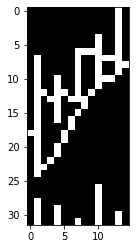

tensor([0.4593, 0.4419, 0.5742, 0.5380, 0.4609, 0.4933, 0.4834, 0.4407, 0.4695,
        0.4086, 0.4746, 0.4389, 0.6193, 0.5206, 0.3546, 0.3809, 0.4490, 0.4399,
        0.5805, 0.5260, 0.5142, 0.5678, 0.3808, 0.4102, 0.4675, 0.5938, 0.4701,
        0.4842, 0.5329, 0.5081, 0.4640, 0.4063, 0.4814, 0.5545, 0.4616, 0.4921,
        0.4372, 0.4408, 0.5293, 0.4364, 0.6047, 0.4352, 0.4250, 0.5939, 0.4965,
        0.5427, 0.4475, 0.5195, 0.5117, 0.4022, 0.5767, 0.5512, 0.5331, 0.4516,
        0.5155, 0.4404, 0.3667, 0.4040, 0.5134, 0.5024, 0.4712, 0.4084, 0.5520,
        0.5706, 0.4007, 0.4362, 0.5300, 0.4378, 0.4626, 0.5944, 0.3874, 0.4554,
        0.4151, 0.4236, 0.4911, 0.4710, 0.5049])

In [920]:
# Sanity check if input and output looks correct
plt.imshow(np.array(inputs[0])*255, cmap='gray', interpolation='nearest')
plt.show()
outputs[:,0]

#### Classification Performance

In [998]:
# Evaluate performance on validation set

model_i5.eval()

true_labels = []
predicted_labels = []
probabilities = []

with torch.no_grad():
    for data_v in valid_dataloader:
        inputs, labels = data_v
        inputs = inputs.view(-1, image_height, image_width)
        outputs = model_i5(inputs)
        probabilities.extend(outputs[:,1].unsqueeze(1).numpy().flatten())
        predicted = (outputs[:,1].unsqueeze(1) > 0.5).float()
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy().flatten())
        

# Performance metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)

# Table 3

Accuracy: 0.53
Precision: 0.54
Recall: 0.62
F1-score: 0.58
Confusion Matrix:
[[ 6726  8997]
 [ 6627 10751]]


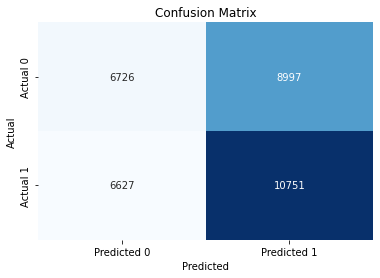

In [1003]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Figure 5

AUC-ROC: 0.53
AUC-PR: 0.55
MCC: 0.05


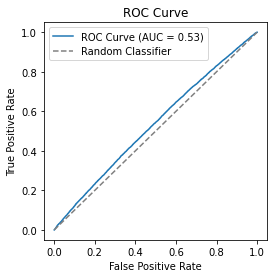

In [1005]:
# Evaluate ROC metrics
auc_roc = roc_auc_score(true_labels, probabilities)
print(f'AUC-ROC: {auc_roc:.2f}')
precision, recall, _ = precision_recall_curve(true_labels, probabilities)
auc_pr = auc(recall, precision)
print(f'AUC-PR: {auc_pr:.2f}')
mcc = matthews_corrcoef(true_labels, predicted_labels)
print(f'MCC: {mcc:.2f}')

fpr, tpr, _ = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
# Figure 6

---
## Part IV: Prediction and Investment Performance
The code below evaluates investment performance over the testing period.

#### Functions

In [924]:
# Transform image data from csv to desired image format
def transform_to_x_input(x, h, w):
    x = x.apply(ast.literal_eval)
    x = np.array([np.array(a) for a in x])
    x = x.reshape(-1, h, w).astype(np.uint8)
    return x

# Get probability predictions from the model
# 'inputs' must be in correct tensor form
def get_prob_predictions(inputs, model):
    with torch.no_grad():
        outputs = model(inputs)
        out = outputs[:, 1].unsqueeze(1).numpy().flatten()
        return out

#### Parameters

In [932]:
q_trade = 0.2 # top/bottom quantile to go long/short
q_min = 8 # min stocks to go long/short

#### Creating Historical Portfolio
On a weekly basis, we predict probabilities for the stocks in the dataset. A dataframe is built which contains:\
`start date | end date | ticker | probability | rank | quantile | forward return | position | weight | weighted return | weighted return long`.

In [926]:
# Get data and create date sequence using NPN ticker
data_backtest = data[pd.to_datetime(data['end_date']) >= backtest_start]
backtest_dates = data_backtest[data_backtest['ticker'] == 'NPN']['end_date']
backtest_dates = backtest_dates.reset_index()['end_date'][list(range(0, len(backtest_dates)-1, 5))]
last_train_date = data[pd.to_datetime(data['end_date']) < backtest_start].iloc[-1]['end_date']

In [927]:
# Load the trained model
model_i5 = i5CNN()
optimizer = optim.Adam(model_i5.parameters(), lr=learn_rate)

checkpoint_path = 'Models/save/i5r5_original.pth' # this is the original model presented in the report
# checkpoint_path = 'Models/save/i5r5.pth' # uncomment this line to load a newly trained model
checkpoint = torch.load(checkpoint_path)
model_i5.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
valid_loss = checkpoint['valid_loss']

model_i5.eval()

# Output 3

i5CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (DropOut): Dropout(p=0.5, inplace=False)
  (FC): Linear(in_features=15360, out_features=2, bias=True)
  (Softmax): Softmax(dim=1)
)

In [1009]:
# TRADING RULES:
# - Hold stocks for next week
# - Equal weight
# - Benchmark is long all stocks at equal weight
# - Rich Version:
#      - Long the top 20% quantile (or top 8 ranked stocks, whichever allows for more stocks)
# - Poor version:
#      - Buy the bottom 20% quantile (or bottom 8 ranked stocks, allows for more stocks)


# Loop through backtest dates and create prediction dataframe
df_predictions = pd.DataFrame(columns=['start_date', 'end_date', 'ticker', 'probability', 'rank', 'quantile', 'fwd_ret_5',\
                                      'position', 'weight_short', 'weighted_return_short',\
                                       'weight_long', 'weighted_return_long'])
for date in backtest_dates:
    
    tmp_data = data_backtest[data_backtest['end_date'] == date]
    x_ = tmp_data['img_data']
    x_ = transform_to_x_input(x_, image_height, image_width)
    
    # Get model predictions
    inputs = torch.stack([torch.from_numpy(arr/255) for arr in x_])
    probs = get_prob_predictions(inputs, model_i5)
    rank = np.argsort(probs).argsort() + 1
    quantile = (probs-min(probs))/(max(probs)-min(probs))
    
    # Craft dataframe entries
    df_temp = pd.DataFrame({
    'start_date': tmp_data['start_date'],
    'end_date': tmp_data['end_date'],
    'ticker': tmp_data['ticker'],
    'probability': probs,
    'rank': rank,
    'quantile': quantile,
    'fwd_ret_5': tmp_data['Fwd_Ret_5']})
    
    # Find how many stocks to long/short
    n_stocks = max([int(len(probs)*q_trade), q_min])
    
    # Add position (1 for long, -1 for short)
    df_temp['position'] = 0
    df_temp.loc[df_temp['rank'] <= n_stocks, 'position'] = -1
    df_temp.loc[df_temp['rank'] >= len(probs) - n_stocks + 1, 'position'] = 1
    
    # Add weight and weighted return
    df_temp['weight_short'] = df_temp['position'] / n_stocks
    df_temp.loc[df_temp['position'] > 0, 'weight_short'] = 0
    #df_temp['weight_short'] = df_temp['weight_short']*-1
    df_temp['weighted_return_short'] = df_temp['weight_short'] * df_temp['fwd_ret_5']
    df_temp['weighted_long'] = df_temp['position'] / n_stocks
    df_temp.loc[df_temp['position'] < 0, 'weighted_long'] = 0
    df_temp['weighted_return_long'] = df_temp['weighted_long'] * df_temp['fwd_ret_5']
    df_predictions = pd.concat([df_predictions, df_temp], ignore_index=True)

In [1010]:
# Get results
df_results = df_predictions.groupby(['end_date']).agg({'weighted_return_short': 'sum'}).reset_index()
df_results.rename(columns={'end_date': 'start_date', 'weighted_return_short': 'poor_portfolio_return'}, inplace=True)
bm_return = df_predictions.groupby(['end_date']).agg({'fwd_ret_5': 'mean'}).reset_index()
long_return = df_predictions.groupby(['end_date']).agg({'weighted_return_long': 'sum'}).reset_index()
long_return.rename(columns={'end_date': 'start_date', 'weighted_return_long': 'rich_portfolio_return'}, inplace=True)
df_results['rich_portfolio_return'] = long_return['rich_portfolio_return']
df_results['benchmark_return'] = bm_return['fwd_ret_5']
df_results['poor_alpha'] = df_results['poor_portfolio_return'] - df_results['benchmark_return']
df_results['rich_alpha'] = df_results['rich_portfolio_return'] - df_results['benchmark_return']
df_results['poor_portfolio_cumulative'] = (1 + df_results['poor_portfolio_return']).cumprod()
df_results['rich_portfolio_cumulative'] = (1 + df_results['rich_portfolio_return']).cumprod()
df_results['benchmark_cumulative'] = (1 + df_results['benchmark_return']).cumprod()

#### Analyse Historical Portfolio Performance

In [1011]:
# Performance Stats
first_row = pd.DataFrame({
    'start_date': last_train_date,
    'poor_portfolio_return': [0],
    'rich_portfolio_return': [0],
    'benchmark_return': [0],
    'poor_alpha': [0],
    'rich_alpha': [0],
    'poor_portfolio_cumulative': [1],
    'rich_portfolio_cumulative': [1],
    'benchmark_cumulative': [1]})
df_results = pd.concat([first_row, df_results], ignore_index=True)

# Annualised Return
def annual_ret(r):
    return(1+r.mean())**52-1

# Annualised Standard deviation
def annual_sd(r):
    sd = r.std()
    return sd*math.sqrt(52)

r1 = annual_ret(df_results['poor_portfolio_return'])
r2 = annual_ret(df_results['rich_portfolio_return'])
r3 = annual_ret(df_results['benchmark_return'])
print(f'Poor Portfolio Annualised Return: {r1*100:.2f}%')
print(f'Rich Portfolio Annualised Return: {r2*100:.2f}%')
print(f'Benchmark Annualised Return: {r3*100:.2f}%')
print('---------------------------')
sd1 = annual_sd(df_results['poor_portfolio_return'])
sd2 = annual_sd(df_results['rich_portfolio_return'])
sd3 = annual_sd(df_results['benchmark_return'])
print(f'Poor Portfolio Annualised SD: {sd1*100:.2f}%')
print(f'Rich Portfolio Annualised SD: {sd2*100:.2f}%')
print(f'Benchmark Annualised SD: {sd3*100:.2f}%')
print('---------------------------')
print(f'Poor Portfolio Annualised Sharpe: {r1/sd1:.2f}')
print(f'Rich Portfolio Annualised Sharpe: {r2/sd2:.2f}')
print(f'Benchmark Annualised Sharpe: {r3/sd3:.2f}')
print('---------------------------')
c1 = pd.to_numeric(df_results['poor_portfolio_cumulative'].iloc[-1])
c2 = pd.to_numeric(df_results['rich_portfolio_cumulative'].iloc[-1])
c3 = pd.to_numeric(df_results['benchmark_cumulative'].iloc[-1])
print(f'Poor Portfolio Growth of R100: R{c1*100:.2f}')
print(f'Rich Portfolio Growth of R100: R{c2*100:.2f}')
print(f'Benchmark Growth of R100: R{c3*100:.2f}')

# Table 4

Poor Portfolio Annualised Return: -12.63%
Rich Portfolio Annualised Return: 22.79%
Benchmark Annualised Return: 11.76%
---------------------------
Poor Portfolio Annualised SD: 23.96%
Rich Portfolio Annualised SD: 24.66%
Benchmark Annualised SD: 20.04%
---------------------------
Poor Portfolio Annualised Sharpe: -0.53
Rich Portfolio Annualised Sharpe: 0.92
Benchmark Annualised Sharpe: 0.59
---------------------------
Poor Portfolio Growth of R100: R23.92
Rich Portfolio Growth of R100: R457.48
Benchmark Growth of R100: R220.83


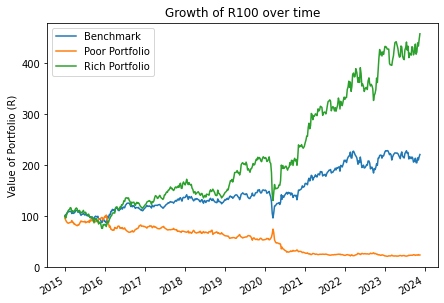

In [1012]:
# Cumulative Performance
df = df_results
df['start_date'] = pd.to_datetime(df['start_date'])
df.set_index('start_date', inplace=True)
df[['benchmark_cumulative', 'poor_portfolio_cumulative', 'rich_portfolio_cumulative']] *= 100
ax = df[['benchmark_cumulative', 'poor_portfolio_cumulative', 'rich_portfolio_cumulative']].plot(kind='line', figsize=(7, 5))
ax.set_xlabel('')
ax.set_ylabel('Value of Portfolio (R)')
ax.set_title('Growth of R100 over time')
ax.legend(['Benchmark', 'Poor Portfolio', 'Rich Portfolio'])
plt.show()

# Figure 7

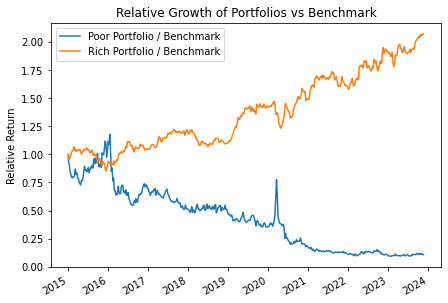

In [1013]:
# Relative Performance
df_relative = df[['poor_portfolio_cumulative', 'rich_portfolio_cumulative']].div(df['benchmark_cumulative'], axis=0)
ax = df_relative.plot(kind='line', figsize=(7, 5))
ax.set_xlabel('')
ax.set_ylabel('Relative Return')
ax.set_title('Relative Growth of Portfolios vs Benchmark')
ax.legend(['Poor Portfolio / Benchmark', 'Rich Portfolio / Benchmark'])
plt.show()

# Figure 8